# AKARI-NEP master catalogue
## Preparation of AKARI-NEP-OptNIR data

This product contains the 8-band (u*, g', r', i', z', Y, J, Ks) optical to
near-infrared catalogue from Oi et al., 2014.

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The total magnitude for each band (u*, g', r', i', z', Y, J, Ks).
- There are no aperture mags so we put empty columns in the masterlist.


We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "akari_ra"
DEC_COL = "akari_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'OBJID': "akari_id",
        'RAJ2000': "akari_ra",
        'DEJ2000': "akari_dec",
        'stl':  "akari_stellarity",
        'umag': "m_megacam_u",
        'e_umag': "merr_megacam_u",
        'gmag': "m_megacam_g",
        'e_gmag': "merr_megacam_g",
        'rmag': "m_megacam_r",
        'e_rmag': "merr_megacam_r",
        'imag': "m_megacam_i",
        'e_imag': "merr_megacam_i",
        'zmag': "m_megacam_z",
        'e_zmag': "merr_megacam_z",
        'Ymag': "m_wircam_y",
        'e_Ymag': "merr_wircam_y",
        'Jmag': "m_wircam_j",
        'e_Jmag': "merr_wircam_j",
        'Kmag': "m_wircam_k",
        'e_Kmag': "merr_wircam_k"
    })


catalogue = Table.read("../../dmu0/dmu0_AKARI-NEP-OptNIR/data/AKARI-NEP_OptNIR.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2014 #This is the paper year. The observations are multi-epoch

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Bad values = -99
        catalogue[col][catalogue[col] <= -90.] = np.nan
        catalogue[errcol][catalogue[errcol] <= -90.] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data

In [6]:
catalogue[:10].show_in_notebook()

idx,akari_id,akari_ra,akari_dec,akari_stellarity,m_megacam_u,merr_megacam_u,m_megacam_g,merr_megacam_g,m_megacam_r,merr_megacam_r,m_megacam_i,merr_megacam_i,m_megacam_z,merr_megacam_z,m_wircam_y,merr_wircam_y,m_wircam_j,merr_wircam_j,m_wircam_k,merr_wircam_k,f_megacam_u,ferr_megacam_u,flag_megacam_u,f_megacam_g,ferr_megacam_g,flag_megacam_g,f_megacam_r,ferr_megacam_r,flag_megacam_r,f_megacam_i,ferr_megacam_i,flag_megacam_i,f_megacam_z,ferr_megacam_z,flag_megacam_z,f_wircam_y,ferr_wircam_y,flag_wircam_y,f_wircam_j,ferr_wircam_j,flag_wircam_j,f_wircam_k,ferr_wircam_k,flag_wircam_k
,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,
0,1,269.229,66.0392,0.65,nan,nan,nan,nan,23.788,0.099,nan,nan,22.973,0.152,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,1.10866,0.101091,False,nan,nan,False,2.34855,0.328791,False,nan,nan,False,nan,nan,False,nan,nan,False
1,2,269.2702,66.0392,0.98,nan,nan,nan,nan,22.688,0.052,nan,nan,20.445,0.024,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,3.05351,0.146244,False,nan,nan,False,24.0991,0.532705,False,nan,nan,False,nan,nan,False,nan,nan,False
2,3,269.4974,66.0392,0.61,nan,nan,nan,nan,23.494,0.109,nan,nan,23.388,0.172,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,1.45345,0.145916,False,nan,nan,False,1.60251,0.253866,False,nan,nan,False,nan,nan,False,nan,nan,False
3,4,269.2482,66.0398,0.93,nan,nan,24.064,0.111,23.096,0.078,22.434,0.091,22.444,0.129,nan,nan,nan,nan,nan,nan,nan,nan,False,0.859805,0.087902,False,2.09701,0.15065,False,3.85834,0.323383,False,3.82296,0.454219,False,nan,nan,False,nan,nan,False,nan,nan,False
4,5,269.215,66.0398,0.74,nan,nan,23.649,0.075,23.042,0.067,23.11,0.132,22.689,0.143,nan,nan,nan,nan,nan,nan,nan,nan,False,1.26009,0.0870436,False,2.20394,0.136004,False,2.07014,0.25168,False,3.05071,0.401802,False,nan,nan,False,nan,nan,False,nan,nan,False
5,6,269.6501,66.0388,0.95,nan,nan,nan,nan,23.088,0.064,nan,nan,21.875,0.086,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,2.11252,0.124525,False,nan,nan,False,6.45654,0.511416,False,nan,nan,False,nan,nan,False,nan,nan,False
6,7,268.6354,66.0399,0.9,nan,nan,nan,nan,24.56,0.174,23.538,0.159,22.796,0.159,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,0.544503,0.087262,False,1.39572,0.204396,False,2.76439,0.40483,False,nan,nan,False,nan,nan,False,nan,nan,False
7,8,268.5935,66.0396,0.59,nan,nan,22.933,0.038,22.277,0.034,21.918,0.059,22.114,0.071,nan,nan,nan,nan,nan,nan,nan,nan,False,2.43669,0.0852823,False,4.45861,0.139622,False,6.20583,0.337231,False,5.18084,0.338793,False,nan,nan,False,nan,nan,False,nan,nan,False
8,9,269.4868,66.0395,0.75,nan,nan,23.847,0.085,22.776,0.074,22.639,0.109,22.57,0.131,nan,nan,nan,nan,nan,nan,nan,nan,False,1.05003,0.0822043,False,2.81579,0.191914,False,3.19448,0.320702,False,3.40408,0.410721,False,nan,nan,False,nan,nan,False,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_megacam_u', 'merr_megacam_g', 'merr_megacam_r', 'merr_megacam_i', 'merr_megacam_z',
            'merr_wircam_y', 'merr_wircam_j', 'merr_wircam_k']
FLAG_NAME = 'akari_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 85797 sources.
The cleaned catalogue has 85797 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_AKARI-NEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

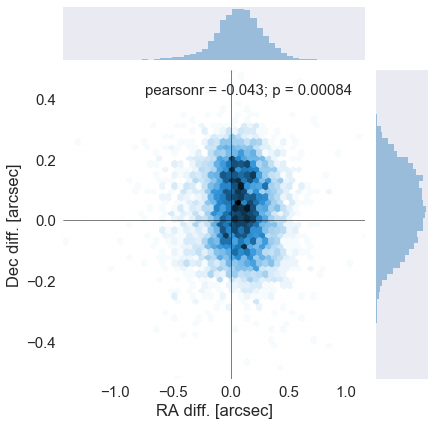

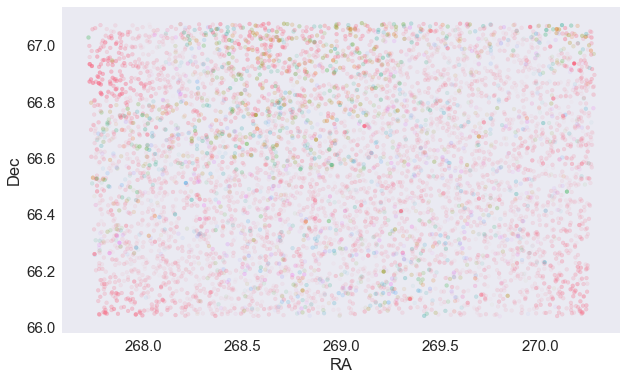

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07950606818667438 arcsec
Dec correction: -0.038150143166149064 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

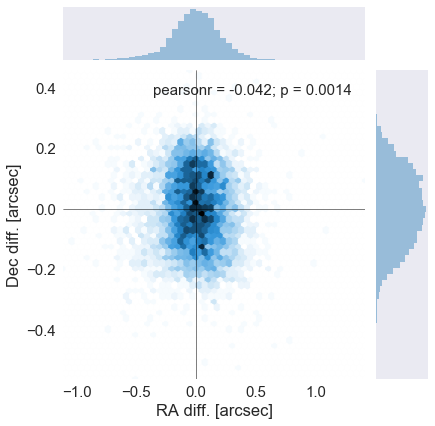

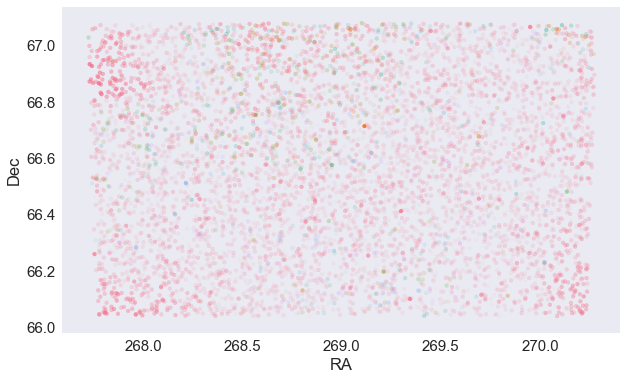

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "akari_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

5953 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/AKARI.fits".format(OUT_DIR), overwrite=True)